# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from tqdm.auto import tqdm

import numpy as np
import h5py

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from torch.optim.lr_scheduler import MultiStepLR, StepLR

In [3]:
!pip install einops

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
os.chdir("/content/drive/MyDrive/MRViT")

In [6]:
from medmnist.info import INFO
from models.mrvit import MultiResViT

In [7]:
data_flag = 'dermamnist'
info = INFO[data_flag]
task = info['task']

In [8]:
from dataset.dataset import get_datasets

In [9]:
random_seed = 101
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = "cuda:0"
    print('using device: cuda')
else:
    device = "cpu"
    print('using device: cpu')

using device: cuda


# Dataset

In [11]:
train_dataset, valid_dataset, test_dataset = get_datasets()

<KeysViewHDF5 ['label_test', 'label_train', 'test', 'test_small', 'train', 'train_small']>
torch.Size([2005, 112, 112, 3]) torch.Size([2005, 28, 28, 3]) torch.Size([2005, 1])
7006 7007


In [12]:
BATCH_SIZE = 128

In [13]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

In [14]:
for batch_data in train_loader:
    print(batch_data[0].shape)
    print(batch_data[1].shape)
    print(batch_data[2].shape)
    break

torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 1])


# Merged Model

In [15]:
mrv = MultiResViT(4)

img_s = torch.randn(2, 3, 224, 224)
img_b = torch.randn(2, 3, 224, 224)

pred = mrv(img_s, img_b)

print(pred)

tensor([[-0.3602, -0.2926,  0.2488, -0.0940],
        [-0.3606, -0.2909,  0.2475, -0.0936]], grad_fn=<AddmmBackward>)


# Training


In [16]:
weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_dataset.get_labels().numpy()),
                                                 train_dataset.get_labels().numpy())
weights = torch.FloatTensor(weights).to(device)

In [17]:
weights

tensor([ 4.5872,  2.7397,  1.3245, 12.6582,  1.3123,  0.2119,  9.8039],
       device='cuda:0')

In [18]:
epochs = 40
lr = 2.5e-4
decay = 0.0
gamma = 0.7

model = MultiResViT(nclasses = 7) #Put model to be trained and tested
model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = MultiStepLR(optimizer, [10, 20, 30])

In [19]:
keys = ['epochs', 'loss', 'acc', 'val_loss', 'val_acc']
history = {key: [] for key in keys}

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in tqdm(train_loader):
        images_s = batch_data[0].to(device)
        images_l = batch_data[1].to(device)
        label = batch_data[2].to(device)

        output = model(images_s, images_l)

        loss = criterion(output.float(), label.flatten())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        acc = accuracy_score(output.argmax(dim=1).detach().cpu().float(), label.detach().cpu().float())
        epoch_accuracy += acc 
        epoch_loss += loss 

    with torch.no_grad(): 
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for batch_data in tqdm(valid_loader):
            images_s = batch_data[0].to(device)
            images_l = batch_data[1].to(device)
            label = batch_data[2].to(device)

            val_output = model(images_s, images_l)
            val_loss = criterion(val_output.float(), label.flatten())

            acc = accuracy_score(val_output.argmax(dim=1).detach().cpu().float(), label.detach().cpu().float())
            epoch_val_accuracy += acc 
            epoch_val_loss += val_loss
    
    scheduler.step()

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss/ len(train_loader):.4f} - acc: {epoch_accuracy/ len(train_loader):.4f} \
        - val_loss : {epoch_val_loss / len(valid_loader):.4f} - val_acc: {epoch_val_accuracy / len(valid_loader):.4f}\n"
    )
    history['epochs'].append(epoch+1)
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_accuracy)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_accuracy)


Epoch : 1 - loss : 1.1110 - acc: 0.6727         - val_loss : 1.6524 - val_acc: 0.4286




Epoch : 2 - loss : 0.9114 - acc: 0.6771         - val_loss : 1.6878 - val_acc: 0.4286




Epoch : 3 - loss : 0.8829 - acc: 0.6831         - val_loss : 1.6980 - val_acc: 0.4286




Epoch : 4 - loss : 0.8601 - acc: 0.6856         - val_loss : 1.4229 - val_acc: 0.4286




Epoch : 5 - loss : 0.8454 - acc: 0.6873         - val_loss : 1.5906 - val_acc: 0.4286




Epoch : 6 - loss : 0.8279 - acc: 0.6914         - val_loss : 1.4353 - val_acc: 0.4286




Epoch : 7 - loss : 0.8154 - acc: 0.6985         - val_loss : 1.7326 - val_acc: 0.4286




Epoch : 8 - loss : 0.8028 - acc: 0.7039         - val_loss : 1.9077 - val_acc: 0.4286




Epoch : 9 - loss : 0.7860 - acc: 0.7080         - val_loss : 1.6789 - val_acc: 0.4286




Epoch : 10 - loss : 0.7829 - acc: 0.7078         - val_loss : 1.5927 - val_acc: 0.4286




Epoch : 11 - loss : 0.7366 - acc: 0.7286         - val_loss : 1.5603 - val_acc: 0.4286




Epoch : 12 - loss : 0.7110 - acc: 0.7320         - val_loss : 1.7353 - val_acc: 0.4286




Epoch : 13 - loss : 0.7015 - acc: 0.7350         - val_loss : 1.5977 - val_acc: 0.4286




Epoch : 14 - loss : 0.6925 - acc: 0.7358         - val_loss : 1.6499 - val_acc: 0.4286




Epoch : 15 - loss : 0.6829 - acc: 0.7434         - val_loss : 1.6121 - val_acc: 0.4286




Epoch : 16 - loss : 0.6768 - acc: 0.7385         - val_loss : 1.5560 - val_acc: 0.4286




Epoch : 17 - loss : 0.6662 - acc: 0.7426         - val_loss : 1.4650 - val_acc: 0.4286




Epoch : 18 - loss : 0.6547 - acc: 0.7454         - val_loss : 1.4277 - val_acc: 0.4286




Epoch : 19 - loss : 0.6546 - acc: 0.7487         - val_loss : 1.4008 - val_acc: 0.4286




Epoch : 20 - loss : 0.6418 - acc: 0.7525         - val_loss : 1.2497 - val_acc: 0.4286




Epoch : 21 - loss : 0.6247 - acc: 0.7563         - val_loss : 1.2082 - val_acc: 0.4286




Epoch : 22 - loss : 0.6249 - acc: 0.7578         - val_loss : 1.1462 - val_acc: 0.4286




Epoch : 23 - loss : 0.6225 - acc: 0.7603         - val_loss : 1.1652 - val_acc: 0.4286




Epoch : 24 - loss : 0.6234 - acc: 0.7562         - val_loss : 1.2463 - val_acc: 0.4286




Epoch : 25 - loss : 0.6235 - acc: 0.7615         - val_loss : 1.2848 - val_acc: 0.4286




Epoch : 26 - loss : 0.6212 - acc: 0.7665         - val_loss : 1.2397 - val_acc: 0.4286




Epoch : 27 - loss : 0.6177 - acc: 0.7609         - val_loss : 1.1117 - val_acc: 0.4286




Epoch : 28 - loss : 0.6157 - acc: 0.7624         - val_loss : 1.2100 - val_acc: 0.4286




Epoch : 29 - loss : 0.6185 - acc: 0.7604         - val_loss : 1.1212 - val_acc: 0.4286




Epoch : 30 - loss : 0.6156 - acc: 0.7643         - val_loss : 1.1636 - val_acc: 0.4286




Epoch : 31 - loss : 0.6133 - acc: 0.7661         - val_loss : 1.1148 - val_acc: 0.4286




Epoch : 32 - loss : 0.6097 - acc: 0.7645         - val_loss : 1.2323 - val_acc: 0.4286




Epoch : 33 - loss : 0.6134 - acc: 0.7636         - val_loss : 1.0769 - val_acc: 0.4286




Epoch : 34 - loss : 0.6088 - acc: 0.7631         - val_loss : 1.1584 - val_acc: 0.4286




Epoch : 35 - loss : 0.6094 - acc: 0.7653         - val_loss : 1.1436 - val_acc: 0.4286




Epoch : 36 - loss : 0.6068 - acc: 0.7660         - val_loss : 1.1665 - val_acc: 0.4286




Epoch : 37 - loss : 0.6124 - acc: 0.7626         - val_loss : 1.1392 - val_acc: 0.4286




Epoch : 38 - loss : 0.6137 - acc: 0.7680         - val_loss : 1.2144 - val_acc: 0.4286




Epoch : 39 - loss : 0.6111 - acc: 0.7659         - val_loss : 1.1028 - val_acc: 0.4286




Epoch : 40 - loss : 0.6114 - acc: 0.7691         - val_loss : 1.1974 - val_acc: 0.4286



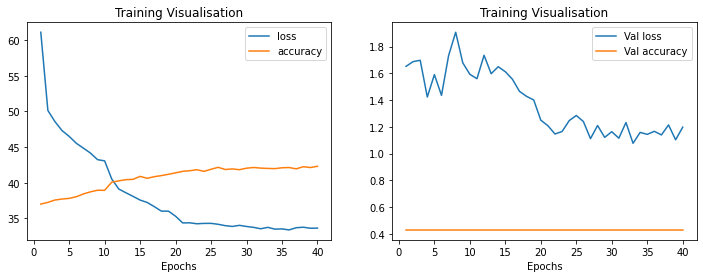

In [20]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['epochs'], history['loss'], label='loss') 
plt.plot(history['epochs'], history['acc'], label='accuracy')
plt.xlabel('Epochs')
plt.title("Training Visualisation")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['epochs'], history['val_loss'], label='Val loss')
plt.plot(history['epochs'], history['val_acc'], label='Val accuracy')
plt.xlabel('Epochs')
plt.title("Training Visualisation")
plt.legend()

In [21]:
test_acc = 0
test_auc = 0
preds = []

with torch.no_grad():
    model.eval()
    for batch_data in tqdm(test_loader):
        images_s = batch_data[0].to(device)
        images_l = batch_data[1].to(device)
        label = batch_data[2].to(device)

        test_output = model(images_s, images_l)
        
        acc = accuracy_score(label.detach().cpu().float(), test_output.argmax(dim=1).detach().cpu().float()) 
        auc = roc_auc_score(F.one_hot(label, num_classes=7)[:, 0, :].detach().cpu().float(), test_output.detach().cpu().float() / torch.sum(test_output).cpu(), multi_class="ovo")
        preds.append(test_output.argmax(dim=1).detach().cpu().numpy())

        test_acc += acc
        test_auc += auc

preds = [a.squeeze().tolist() for a in preds]

RuntimeError: ignored

In [ ]:
print(f"ACC Model: {test_acc / len(test_loader)}, AUC Model: {test_auc / len(test_loader)}")

In [ ]:
print(classification_report(test_dataset.get_labels(), preds[0]))